In [1]:
import os
import sys

from pathlib import Path


# si aggiunge al path la cartella utils per avere visibilità del module
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import timm
import torch
import numpy as np
import pandas as pd
import utils.mining as mining
import utils.datasets as build
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from skimage import io
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import miners, losses
from sklearn.model_selection import train_test_split

In [3]:
# serve per ricaricare il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# configurazione
batch_size=32
lr=0.001
epochs=30
device="cuda"

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="fourier"

# margin per semi-hard mining con modello pre-allenato
margin=0.2

In [5]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent

fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")

In [6]:
# carica le immagini nel dataset
class ApnDataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    # le immagini Anchor sono memorizzate in due dataset diversi
    if str(row.Anchor).startswith("coco"):
      a_img = io.imread(os.path.join(real_data_dir, row.Anchor))
      p_img = io.imread(os.path.join(real_data_dir, row.Positive))
      n_img = io.imread(os.path.join(fake_data_dir, row.Negative))

      a_label = 0
      p_label = 0
      n_label = 1

    else:
      a_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
      p_img = io.imread(os.path.join(fake_data_dir, row.Positive))
      n_img = io.imread(os.path.join(real_data_dir, row.Negative))

      a_label = 1
      p_label = 1
      n_label = 0
    
    if mode == "rgb":
      # normalizzazione per immagini in rgb 
      a_img = torch.from_numpy(a_img).permute(2, 0, 1) / 255.0
      p_img = torch.from_numpy(p_img).permute(2, 0, 1) / 255.0
      n_img = torch.from_numpy(n_img).permute(2, 0, 1) / 255.0

      a_label = torch.tensor(a_label)
      p_label = torch.tensor(p_label)
      n_label = torch.tensor(n_label)

    if mode == "fourier":
      a_img = rgb2gray(a_img)
      p_img = rgb2gray(p_img)
      n_img = rgb2gray(n_img)

      a_img = np.expand_dims(a_img, 0)
      p_img = np.expand_dims(p_img, 0)
      n_img = np.expand_dims(n_img, 0)
      
      a_img = torch.from_numpy(a_img) / 255.0
      p_img = torch.from_numpy(p_img) / 255.0
      n_img = torch.from_numpy(n_img) / 255.0
      
      """
      # trasformata di fourier
      a_img = np.fft.fft2(a_img)
      p_img = np.fft.fft2(p_img)
      n_img = np.fft.fft2(n_img)

      fft_img = np.log(np.abs(fft_img))
      """

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return a_img, p_img, n_img, a_label, p_label, n_label

In [7]:
# classe per caricare il modello di rete neurale direttamente dalle repository online
class ApnModel(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size=512):
    super(ApnModel, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b1", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [8]:
# classe del modello che genera gli embedding per applicare il semi-hard mining
class EmbModel(nn.Module):

    # size del vettore di embedding
    def __init__(self, emb_size = 512):
        super(EmbModel, self).__init__()

        # gli embedding vengono creati con un modello preallenato (risultato più efficace in test precedenti)
        self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [9]:
# funzione per creare embeddings che sarranno sottoposti a semi-hard mining
def create_embeddings(model, dataloader, device): 
    # off dropout
    model.eval()

    list_df = []

    with torch.no_grad():
        for a, p, n, al, pl, nl in tqdm(dataloader, desc="creating embeddings..."):
            a, p, n = a.float().to(device), p.float().to(device), n.float().to(device)

            temp_df_embs = pd.DataFrame(columns=["Anchor_embs", "Positive_embs", "Negative_embs"])

            a_embs = model(a)
            p_embs = model(p)
            n_embs = model(n)
            
            # la batch size può variare, perciò ci si basa sulla lunghezza del tensore
            batch_size = len(a_embs)
            
            # ad ogni batch corrisponde un dataframe
            for i in range(batch_size): 
                # si serializzano gli array np in stringhe in modo da memorizzarli nelle celle del datagrame
                a, p, n = a_embs[i].cpu().numpy(), p_embs[i].cpu().numpy(), n_embs[i].cpu().numpy()
                a, p, n = np.array2string(a, separator=','), np.array2string(p, separator=','), np.array2string(n, separator=',')
                
                temp_df_embs.loc[i] = [
                    a, 
                    p, 
                    n
                ]
            
            list_df.append(temp_df_embs)

    # concatenazione di tutti i dataframe
    df_embs = pd.concat(list_df)

    return df_embs

In [10]:
emb_model = EmbModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "fourier":
    emb_model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

emb_model.to(device);

In [11]:
path = Path(os.getcwd()).parent.parent
fake_dataset_path = os.path.join(path, "artifact", "taming_transformer", "metadata.csv")
real_dataset_path = os.path.join(path, "artifact", "coco", "metadata.csv")

df_out_path = os.path.join("..", "datasets", "out.csv")
df_out = pd.read_csv(df_out_path)

In [12]:
apn_dataset = ApnDataset(df_out)
dataloader = DataLoader(apn_dataset, batch_size=batch_size)

In [13]:
emb_csv_path = os.path.join("..", "notebooks", "embeddings.csv")

# si controlla che siano stati già creati gli embeddings
if not Path(emb_csv_path).is_file():
    df_emb = create_embeddings(emb_model, dataloader, device)
    df_emb.to_csv(emb_csv_path, index=False)

df_emb = pd.read_csv(emb_csv_path)

creating embeddings...:   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|█████████▉| 1562/1563 [1:26:46<00:01,  1.95s/it]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
creating embeddings...: 100%|██████████| 1563/1563 [1:26:47<00:00,  3.33s/it]


In [14]:
# si concatenano i dataframe delle immagini e degli embeddings sulle colonne per poter filtrare le righe in logica di semi-hard mining
df_out = pd.concat([df_out, df_emb], axis=1)

# offline semi-hard mining dei triplets
df_out = mining.offline_semi_hard_mining(df_out, margin)
df_out = df_out.drop(["Anchor_embs", "Positive_embs", "Negative_embs"], axis=1)

print(f"dataset size after semi-hard mining: {len(df_out)}")

dataset size after semi-hard mining: 25090


In [15]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion, miner):
  # on dropout 
  model.train()
  
  total_loss = 0.0

  for a, p, n, al, pl, nl in tqdm(dataloader, desc="model training..."):
    a, p, n = a.float().to(device), p.float().to(device), n.float().to(device)
    al, pl, nl = al.to(device), pl.to(device), nl.to(device)

    optimizer.zero_grad()

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    # per usare l'ohm si devono concatenare tutti i tipi di immagine, i triplet verranno creati nella funzione di loss
    embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
    labels = torch.cat((al, pl, nl), axis=0)

    # online hard mining prima del calcolo della loss
    miner_output = miner(embeddings, labels)
    loss = criterion(embeddings, labels, miner_output)
    loss.backward()
    
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [16]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion, miner):
  # off dropout
  model.eval() 
  
  total_loss = 0.0

  with torch.no_grad():
    for a, p, n, al, pl, nl in tqdm(dataloader, desc="model validating..."):
      a, p, n = a.float().to(device), p.float().to(device), n.float().to(device)
      al, pl, nl = al.to(device), pl.to(device), nl.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)
      
      embeddings = torch.cat((a_embs, p_embs, n_embs), axis=0)
      labels = torch.cat((al, pl, nl), axis=0)
      
      miner_output = miner(embeddings, labels)
      loss = criterion(embeddings, labels, miner_output)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
model = ApnModel()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "fourier":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(device);

ApnModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=

In [18]:
# split del nuovo dataframe
train_df, valid_df = train_test_split(df_out, test_size=0.20, random_state=42)

trainset = ApnDataset(train_df)
validset = ApnDataset(valid_df)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [19]:
# triplet loss, miner (per online hard mining) e adam
criterion = losses.TripletMarginLoss(triplets_per_anchor="all")
miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="hard")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion, miner)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model training...: 100%|█████████▉| 627/628 [25:01<00:02,  2.27s/it]c:\Users\raffa\anaconda3\envs\fvab\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
model validating...: 100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


successful weights saving...
epochs: 1, train_loss: 0.052693037304339135, valid_loss: 0.049941900476908226


model validating...: 100%|██████████| 157/157 [01:12<00:00,  2.15it/s]


epochs: 2, train_loss: 0.05011539342131015, valid_loss: 0.049971405013351684


model validating...: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s]


epochs: 3, train_loss: 0.050068830756862075, valid_loss: 0.049974700163124476


model validating...: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]


epochs: 4, train_loss: 0.050064718949899174, valid_loss: 0.049973285074826256


model validating...: 100%|██████████| 157/157 [01:28<00:00,  1.78it/s]


epochs: 5, train_loss: 0.05006518052404473, valid_loss: 0.049965964025183086


model validating...: 100%|██████████| 157/157 [01:11<00:00,  2.19it/s]


epochs: 6, train_loss: 0.05006702070474435, valid_loss: 0.04995967922316995


model validating...: 100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


epochs: 7, train_loss: 0.0500688411912341, valid_loss: 0.0499550716559978


model validating...: 100%|██████████| 157/157 [01:07<00:00,  2.31it/s]


epochs: 8, train_loss: 0.05007156055824012, valid_loss: 0.04995291205538306


model validating...: 100%|██████████| 157/157 [01:29<00:00,  1.75it/s]


successful weights saving...
epochs: 9, train_loss: 0.050073952835266757, valid_loss: 0.0499233155256244


model validating...: 100%|██████████| 157/157 [01:11<00:00,  2.20it/s]


epochs: 10, train_loss: 0.0500770041090288, valid_loss: 0.04993265561142545


model validating...: 100%|██████████| 157/157 [01:08<00:00,  2.30it/s]


successful weights saving...
epochs: 11, train_loss: 0.05007959162567262, valid_loss: 0.04990066469285139


model validating...: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]


successful weights saving...
epochs: 12, train_loss: 0.050082212420785505, valid_loss: 0.049863678610818404


model validating...: 100%|██████████| 157/157 [01:31<00:00,  1.72it/s]


successful weights saving...
epochs: 13, train_loss: 0.0500849436339774, valid_loss: 0.04984023467085923


model validating...: 100%|██████████| 157/157 [01:12<00:00,  2.15it/s]


successful weights saving...
epochs: 14, train_loss: 0.050087849111266576, valid_loss: 0.049814678277749165


model validating...: 100%|██████████| 157/157 [01:08<00:00,  2.29it/s]


epochs: 15, train_loss: 0.05009073026739298, valid_loss: 0.04987489548363504


model validating...: 100%|██████████| 157/157 [01:07<00:00,  2.31it/s]


epochs: 16, train_loss: 0.05009197733798035, valid_loss: 0.04984222233864912


model validating...: 100%|██████████| 157/157 [01:31<00:00,  1.72it/s]


epochs: 17, train_loss: 0.05009326222500983, valid_loss: 0.049830150689668715


model validating...: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s]


epochs: 18, train_loss: 0.0500952966902761, valid_loss: 0.04983195695717623


model validating...: 100%|██████████| 157/157 [01:08<00:00,  2.28it/s]


successful weights saving...
epochs: 19, train_loss: 0.05009633984274355, valid_loss: 0.049767085653581435


model validating...: 100%|██████████| 157/157 [01:07<00:00,  2.34it/s]


epochs: 20, train_loss: 0.050098391967546785, valid_loss: 0.04982695768877959


model validating...: 100%|██████████| 157/157 [01:28<00:00,  1.77it/s]


successful weights saving...
epochs: 21, train_loss: 0.050099381714299986, valid_loss: 0.049766629886854985


model validating...: 100%|██████████| 157/157 [01:12<00:00,  2.18it/s]


successful weights saving...
epochs: 22, train_loss: 0.050099679061276894, valid_loss: 0.04974562871702917


model validating...: 100%|██████████| 157/157 [01:08<00:00,  2.30it/s]


successful weights saving...
epochs: 23, train_loss: 0.05010108631934709, valid_loss: 0.04965402494380428


model validating...: 100%|██████████| 157/157 [01:06<00:00,  2.35it/s]


epochs: 24, train_loss: 0.05010193419660543, valid_loss: 0.04966116319321523


model validating...: 100%|██████████| 157/157 [01:29<00:00,  1.75it/s]


successful weights saving...
epochs: 25, train_loss: 0.050103206163758685, valid_loss: 0.049643391114511305


model validating...: 100%|██████████| 157/157 [01:11<00:00,  2.21it/s]


epochs: 26, train_loss: 0.0501026465990551, valid_loss: 0.04964625833045905


model validating...: 100%|██████████| 157/157 [01:08<00:00,  2.29it/s]


successful weights saving...
epochs: 27, train_loss: 0.05010453000024056, valid_loss: 0.0495700440636486


model validating...: 100%|██████████| 157/157 [01:06<00:00,  2.35it/s]


epochs: 28, train_loss: 0.05010323145183598, valid_loss: 0.04957973631988665


model validating...: 100%|██████████| 157/157 [01:30<00:00,  1.73it/s]


epochs: 29, train_loss: 0.05010577788351068, valid_loss: 0.049623602206350134


model validating...: 100%|██████████| 157/157 [01:11<00:00,  2.19it/s]

epochs: 30, train_loss: 0.05010809881055051, valid_loss: 0.049570569519404396


<function matplotlib.pyplot.show(close=None, block=None)>

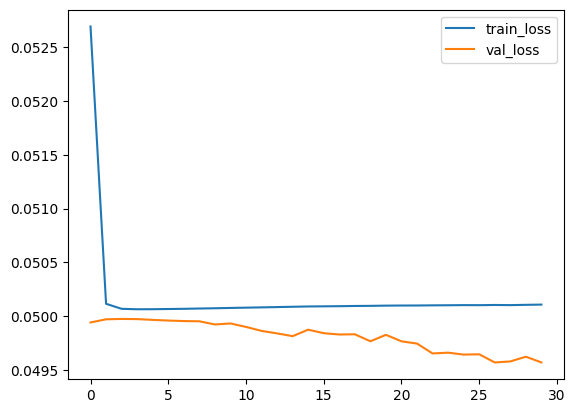

In [21]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [31]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dir_folder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr, desc="creating encodings..."):
      if str(i).startswith("coco"):
        dir_folder = real_data_dir
      else: 
        dir_folder = fake_data_dir
      
      a = io.imread(os.path.join(dir_folder, i))

      if mode == "rgb":
        a = torch.from_numpy(a).permute(2, 0, 1) / 255.0
      
      if mode == "fourier":
        a = rgb2gray(a)
        a = np.expand_dims(a, 0)
        a = torch.from_numpy(a.astype(np.int32)) / 255.0
        
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    anc_img_names_df = pd.DataFrame(anc_img_names_arr, columns=['Anchor'])
    df_enc = pd.concat([anc_img_names_df, encodings], axis=1)

    return df_enc

In [32]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df_out["Anchor"], real_data_dir)
df_enc.to_csv("database.csv", index=False)

creating encodings...: 100%|██████████| 25090/25090 [13:49<00:00, 30.25it/s]


In [33]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,coco/coco2017/train2017/img087583.jpg,-5.097686,9.781346,-20.147896,-11.339385,-15.215671,6.559587,3.023787,26.299604,-23.619465,...,9.677806,-5.655154,-6.344949,-14.255855,13.303577,5.884014,-3.186222,6.744554,-16.202831,-3.234488
1,coco/coco2017/train2017/img058154.jpg,-5.116282,9.795825,-20.226665,-11.389508,-15.259982,6.601694,3.051465,26.386526,-23.716133,...,9.717127,-5.676010,-6.346604,-14.313428,13.369785,5.898062,-3.216838,6.772049,-16.266815,-3.238270
2,coco/coco2017/train2017/img109565.jpg,-5.129780,9.824825,-20.268770,-11.419039,-15.299984,6.612909,3.061139,26.449583,-23.758470,...,9.738164,-5.695026,-6.368527,-14.353375,13.408033,5.914445,-3.220373,6.778273,-16.303568,-3.251514
3,coco/coco2017/test2017/img012686.jpg,-5.111303,9.820746,-20.225628,-11.388514,-15.258848,6.589541,3.044367,26.401842,-23.705994,...,9.720070,-5.674737,-6.362050,-14.311926,13.370272,5.900932,-3.202605,6.769156,-16.270447,-3.245677
4,coco/coco2017/test2017/img009328.jpg,-5.097686,9.781346,-20.147896,-11.339385,-15.215671,6.559587,3.023787,26.299604,-23.619465,...,9.677806,-5.655154,-6.344949,-14.255855,13.303577,5.884014,-3.186222,6.744554,-16.202831,-3.234488


In [34]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T)
    # dist = np.sqrt(dist)
    return dist

In [36]:
path = Path(os.getcwd()).parent.parent
fake_data_dir = os.path.join(path, "artifact", "taming_transformer")
real_data_dir = os.path.join(path, "artifact", "coco")
fake_dataset_path = os.path.join(fake_data_dir, "metadata.csv")
real_dataset_path = os.path.join(real_data_dir, "metadata.csv")

test_df_path = os.path.join("..", "datasets", "testList.csv")
build.test(fake_dataset_path, real_dataset_path, df_out, test_df_path)
test_df = pd.read_csv(test_df_path)

print(test_df["real"])
print(test_df.size)
test_df.head()

building (fake column) test dataframe...:   4%|▎         | 3732/105000 [00:00<00:00, 1242312.90it/s]

0       coco/coco2017/train2017/img046597.jpg
1       coco/coco2017/train2017/img158236.jpg
2       coco/coco2017/train2017/img149153.jpg
3       coco/coco2017/train2017/img070305.jpg
4       coco/coco2017/train2017/img051465.jpg
                        ...                  
2504     coco/coco2017/test2017/img002430.jpg
2505     coco/coco2017/test2017/img016017.jpg
2506    coco/coco2017/train2017/img092974.jpg
2507     coco/coco2017/test2017/img017391.jpg
2508     coco/coco2017/test2017/img005564.jpg
Name: real, Length: 2509, dtype: object
5018


,real,fake
0,coco/coco2017/train2017/img046597.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/797/img03877...
1,coco/coco2017/train2017/img158236.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/118/img00113...
2,coco/coco2017/train2017/img149153.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img033485.jpg
3,coco/coco2017/train2017/img070305.jpg,tt-ffhq/ffhq_k300_p1.0_fid9.6/img000918.jpg
4,coco/coco2017/train2017/img051465.jpg,tt-cc/cin_k600_p1.0_a0.05_fid5.20/461/img02018...


In [46]:
def get_image_embeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "fourier":
        img = rgb2gray(img)
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
        img = img.float()
    
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [43]:
def search_in_database(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [44]:
path = Path(os.getcwd()).parent.parent
real_dataset_dir = os.path.join(path, "artifact", "coco")
fake_dataset_dir = os.path.join(path, "artifact", "taming_transformer")

y_true = []
y_pred = []

temp_df = test_df
temp_df.head()
temp_df.shape

(2509, 2)

In [47]:
# testo i fake
current_test = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(temp_df.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)

    if str(closest_label).startswith("coco"):
        y_pred.append("real")
    else:
        y_pred.append("fake")

testing on fake images...: 2509it [21:15,  1.97it/s]


In [48]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
2509
['fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 

In [50]:
# testo i real
current_test = "real"
database = df_enc

for index, row in tqdm(temp_df.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_dataset_dir, row[current_test])
    img_name = path

    img = io.imread(img_name)
    img_enc = get_image_embeddings(img, model)
    closest_label = search_in_database(img_enc, database)
    
    if str(closest_label).startswith("coco"):
        y_pred.append("real")
    else:
        y_pred.append("fake")

testing on real images...: 2509it [23:10,  1.80it/s]


In [51]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
5018
['fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 

In [52]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * len(temp_df))
temp = np.array(["real"] * len(temp_df))
y_true = np.concatenate([y_true, temp])

print(y_pred)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

['fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake',

In [53]:
tn, fp, fn, tp = cm.ravel()

# metriche
accuracy = round((tp + tn) / (tp + tn + fp + fn), 4) * 100
precision = round((tp) / (tp + fp), 4) * 100
recall = round((tp) / (tp + fn), 4) * 100
specificity = round((tn) / (tn + fp) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 45.83, 'Precision': 43.51, 'Recall': 27.939999999999998, 'Specificity': 63.7306, 'F1 Score': 34.0285}


In [54]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "rgb_mining", "siamese_" + mode + "_" + "pretrained_semi_hard_online_hard_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)